In [1]:
 # -*- coding: utf-8 -*-
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
import numpy as np
import japanize_matplotlib
import os

train_file = pd.read_csv(r"C:\Users\Kenichi\Documents\Kaggle_Data\kuzushiji_recognition\train.csv")

unicode_chart = pd.read_csv(r"C:\Users\Kenichi\Documents\Kaggle_Data\kuzushiji_recognition\unicode_translation.csv")
train_file.labels = train_file.labels.str.split(' ')
train_file.labels.head(3)

0    [U+306F, 1231, 3465, 133, 53, U+304C, 275, 165...
1    [U+306F, 1087, 2018, 103, 65, U+304B, 1456, 18...
2    [U+306F, 572, 1376, 125, 57, U+306E, 1551, 208...
Name: labels, dtype: object

In [2]:
#changed the train label dimension
label_np = np.array(train_file.labels[0])
label_np = label_np.reshape(int(len(label_np)/5), 5)
label_list = np.array([])
for i in label_np[:, 0]:
    label_list= np.append(label_list, unicode_chart.char[unicode_chart.Unicode == i])
#label_list = pd.DataFrame(label_list, columns=["chart_index", "char"])
print(label_list)

['は' 'が' 'い' 'け' 'に' 'に' 'の' '工' 'こ' '三' 'の' 'や' 'と' '己' 'も' 'さ' 'の' 'の'
 '世' '細' 'そ' '人' 'け' 'れ' 'だ' '強' 'の' 'た' 'て' '俳' '根' 'か' '諧' 'れ' '子' 'を'
 '及' '者' 'ず' '避' '正' '文' 'ふ' '時' '思' 'な' 'め' '浮' 'を' '気' '職' '老' '武' '楽'
 'も' '盲' '若' '自' 'ど' '風' 'に' '裏' '畳' '息' '序' 'し' 'し']


In [104]:
def get_padded_image(crop):
    h, w, ch = crop.shape
    if w > h:
        crop_resize = cv2.resize(crop , (64, int(h/(w/64))))
    else:
        ratio = int(h/64)
        crop_resize = cv2.resize(crop , (int(w/(h/64)), 64))

    n_h, n_w, ch = crop_resize.shape
    #print(int((64 - n_h)/2),int((64 - n_w)/2))
    bg_color = [198, 244, 252]
    if (64 - n_h)%2 == 0 and (64 - n_w)%2 == 0:
        padded_img = cv2.copyMakeBorder(crop_resize,int((64 - n_h)/2), int((64 - n_h)/2), 
                                    int((64 - n_w)/2), int((64 - n_w)/2), cv2.BORDER_CONSTANT, value = bg_color)
    elif (64 - n_h)%2 != 0 and (64 - n_w)%2 == 0:
        padded_img = cv2.copyMakeBorder(crop_resize,int((64 - n_h)/2), int((64 - n_h)/2) + 1, 
                                    int((64 - n_w)/2), int((64 - n_w)/2), cv2.BORDER_CONSTANT, value = bg_color)
    elif (64 - n_h)%2 == 0 and (64 - n_w)%2 != 0:
        padded_img = cv2.copyMakeBorder(crop_resize,int((64 - n_h)/2), int((64 - n_h)/2), 
                                    int((64 - n_w)/2), int((64 - n_w)/2) + 1, cv2.BORDER_CONSTANT, value = bg_color)
            
    return padded_img
for k in range(100):
    label_np = np.array(train_file.labels[k])
    if pd.isnull(label_np).all() == True:
        continue
    label_np = label_np.reshape(int(len(label_np)/5), 5)
    label_list = np.array([])
    for i in label_np[:, 0]:
        label_list= np.append(label_list, unicode_chart.char[unicode_chart.Unicode == i])
    
    image = cv2.imread(os.path.join(r"C:\Users\Kenichi\Documents\Kaggle_Data\kuzushiji_recognition\train_images", train_file.image_id[k] + ".jpg"))
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)   
    height, width, channels = img.shape

#     fig =plt.figure(figsize=(width/200, height/200))
#     ax = fig.add_subplot(1,1,1)
    j = 0
    for i in label_np:
        rect = mpatches.Rectangle((int(i[1]), int(i[2])), int(i[3]), int(i[4]), fill=False, edgecolor='red', linewidth=1)
        ax.add_patch(rect)
        crop = image[ int(i[2]):int(i[2])+int(i[4]), int(i[1]):int(i[1]) + int(i[3]), :]
        crop = get_padded_image(crop)
#         print(crop.shape)
        cv2.imwrite(os.path.join("../../Kaggle_Data/kuzushiji_recognition/cropped", train_file.image_id[k] + 
                                 "_" + str(i[0]) + "_" + str(i[1]) + "_" + str(i[2]) + "_"
                                 + str(i[3]) + "_" + str(i[4]) + ".jpg"), crop)
#         ax.text((int(i[1]) + int(i[3]))/width, 1 - int(i[2])/height, label_list[j],
#                 horizontalalignment='left',fontsize=20,
#                 verticalalignment='center',
#                 rotation='horizontal',
#                 transform=ax.transAxes)
        j = j+1
#     ax.imshow(img)
#     plt.savefig(os.path.join("../../Kaggle_Data/kuzushiji_recognition/anotated", train_file.image_id[k]+"_anotated.jpg"))
#plt.show()


In [96]:
def(crop):
    h, w, ch = crop.shape
    if w > h:
        crop_resize = cv2.resize(crop , (64, int(h/(w/64))))
    else:
        ratio = int(h/64)
        crop_resize = cv2.resize(crop , (int(w/(h/64)), 64))

    n_h, n_w, ch = crop_resize.shape
    print(int((64 - n_h)/2),int((64 - n_w)/2))
    bg_color = [198, 244, 252]
    if int((64 - n_h)/2)%2 == 0 and int((64 - n_w)/2)%2 == 0:
        padded_img = cv2.copyMakeBorder(crop_resize,int((64 - n_h)/2), int((64 - n_h)/2), 
                                    int((64 - n_w)/2), int((64 - n_w)/2), cv2.BORDER_CONSTANT, value = bg_color)
    elif: int((64 - n_h)/2)%2 != 0 and int((64 - n_w)/2)%2 == 0:
        padded_img = cv2.copyMakeBorder(crop_resize,int((64 - n_h)/2), int((64 - n_h)/2) + 1, 
                                    int((64 - n_w)/2), int((64 - n_w)/2), cv2.BORDER_CONSTANT, value = bg_color)
    elif: int((64 - n_h)/2)%2 == 0 and int((64 - n_w)/2)%2 != 0:
        padded_img = cv2.copyMakeBorder(crop_resize,int((64 - n_h)/2), int((64 - n_h)/2) + 1, 
                                    int((64 - n_w)/2), int((64 - n_w)/2) + 1, cv2.BORDER_CONSTANT, value = bg_color)
            
    return padded_img

0 15


(64, 63, 3)


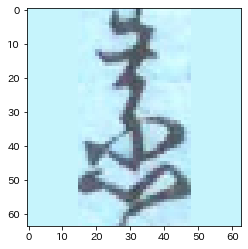

In [97]:
print(padded_img.shape)
plt.imshow(padded_img)

In [44]:
unicode_chart.char[unicode_chart.Unicode == "U+3046"]

53    う
Name: char, dtype: object

In [178]:
i


[1231, 3465, 133, 53]

In [72]:
print(int(1231/width), int(1-3465/height))

0 0


In [159]:
a = [[1,2,3],[4,5,6],[7,8,9]]
for i in a[::7]:
    print(i)


[1, 2, 3]


[[1, 2, 3], [4, 5, 6], [7, 8, 9]]